## A model distinguishing images with dogs from images with cats.
###### Completed as homework for Data Mining In Action free course (https://vk.com/data_mining_in_action), "Trends" direction, spring 2018
###### Dataset is taken from Kaggle competition (https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
###### PyTorch (http://pytorch.org/) is used as Deep Learning framework

Create Dataset class inheritor to load data the way PyTorch examples do (http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) 

In [1]:
from torch.utils.data import Dataset
from PIL import Image

class CatsDogsDataset(Dataset):
    
    def __init__(self, images_folder, filenames, image_size = None, transform=None):
        self.images_folder = images_folder
        self.filenames = filenames
        self.image_size = image_size
        self.transform = transform 
        
    def __len__(self):
        return len(self.filenames)
    
    def get_image(self, image_name):
        image_path = os.path.join(self.images_folder, image_name)
        image = Image.open(image_path)
        
        if (self.image_size):
            image = image.resize(self.image_size)
        
        if (self.transform):
            image = self.transform(image)
            
        return image

In [2]:
class CatsDogsLabeledDataset(CatsDogsDataset):
    
    def __init__(self, images_folder, filenames, image_size = None, transform=None):
        super(CatsDogsLabeledDataset, self).__init__(images_folder, filenames, image_size, transform)
    
    @staticmethod
    def is_dog(image_name):
        return image_name.lower().startswith("dog.")
    
    def __getitem__(self, indx):
        image_name = self.filenames[indx]    
        image = self.get_image(image_name)
        label = int(CatsDogsLabeledDataset.is_dog(image_name))
        
        return [image, label]

Split images in train folder into two datasets for model training and its validation

In [3]:
import os 
from random import shuffle

train_folder = "./train"
validation_dataset_size = 5000

images = os.listdir(train_folder)

shuffle(images)
train_images = images[:-validation_dataset_size]
validation_images = images[-validation_dataset_size:]

Data transforms for neural network usage

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

image_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Create train dataset and loader for it

In [5]:
batch_size = 4

train_dataset = CatsDogsLabeledDataset(
    train_folder,
    train_images,
    image_size = (image_size, image_size),
    transform = transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Check correct loading and transforms

Cat
image shape: torch.Size([3, 64, 64])


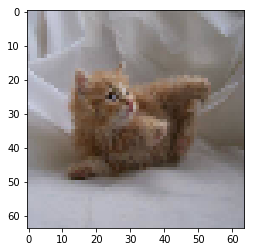

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.imshow(img)


dataiter = iter(train_loader)
images, labels = dataiter.next()
image = images[0]
label = labels[0]

# show image
imshow(image)
print (["Cat", "Dog"][label])
print ("image shape:", image.size())

Declare convolution neural network similar to the PyTorch tutorial (http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolution-neural-network)

In [ ]:
'''from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional

color_channels = 3
kernel_size = 9
kernel_size = 3
pool_window = 2

class TutorialCNN(nn.Module):
    def __init__(self):
        super(TutorialCNN, self).__init__()
        self.activation = functional.relu
        self.conv1 = nn.Conv2d(color_channels, 6, kernel_size)
        self.max_pool = nn.MaxPool2d(pool_window, pool_window)
        self.conv2 = nn.Conv2d(self.conv1.out_channels, 32, kernel_size)
        self.linear_in_features = self.conv2.out_channels * 10 * 10
        self.fc1 = nn.Linear(self.linear_in_features, 120)
        self.fc2 = nn.Linear(self.fc1.out_features, 84)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)

    def forward(self, x):
        layer_output = self.activation(self.conv1(x))
        layer_output = self.max_pool(layer_output)
        layer_output = self.activation(self.conv2(layer_output))
        layer_output = self.max_pool(layer_output)
        layer_output = layer_output.view(-1, self.linear_in_features)
        layer_output = self.activation(self.fc1(layer_output))
        layer_output = self.activation(self.fc2(layer_output))
        layer_output = self.fc3(layer_output)

        # Values from interval [0,1] are needed as answer
        layer_output = functional.sigmoid(layer_output)
        return layer_output

model = TutorialCNN()
 '''

Declare convolution neural network similar to DogsAndCats samples spred out in the internet (like here: http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks)   

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional

color_channels = 3
kernel_size = 3
pool_window = 2

class WithDropoutCNN(nn.Module):
    def __init__(self):
        super(WithDropoutCNN, self).__init__()
        self.conv32 = nn.Conv2d(color_channels, 32, kernel_size)
        
        self.conv64_1 = nn.Conv2d(self.conv32.out_channels, 64, kernel_size)
        self.conv64_2 = nn.Conv2d(self.conv64_1.out_channels, 64, kernel_size)
        
        self.max_pool = nn.MaxPool2d(pool_window, pool_window)
        
        self.linear_in_features = self.conv64_2.out_channels * 13 * 13
        self.fully_conected = nn.Linear(self.linear_in_features, 512)
        
        self.dropout = nn.Dropout(p=0.5)
        self.output = nn.Linear(self.fully_conected.out_features, 1)
        
        self.relu = functional.relu
        
        # Values from interval [0,1] are needed as answer
        self.sigmoid = functional.sigmoid

    def forward(self, x):
        layer_output = self.relu(self.conv32(x))
        layer_output = self.max_pool(layer_output)
        
        layer_output = self.relu(self.conv64_1(layer_output))
        layer_output = self.relu(self.conv64_2(layer_output))
        layer_output = self.max_pool(layer_output)
        
        layer_output = layer_output.view(-1, self.linear_in_features)
        
        layer_output = self.relu(self.fully_conected(layer_output))
        layer_output = self.dropout(layer_output)
        
        layer_output = self.sigmoid(self.output(layer_output))
        return layer_output

In [ ]:
model = WithDropoutCNN()

It looks like LogLoss function is called BCELoss in PyTorch (http://pytorch.org/docs/master/nn.html#bceloss) <br/>
Used SGD with momentum optimizer, as in the tutorial

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the network

In [ ]:
from torch import FloatTensor

report_samples = 1000

for epoch in range(5):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        targets = FloatTensor([[label] for label in labels])
        
        # wrap in Variable
        inputs, targets = Variable(inputs), Variable(targets)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # print statistics every report_steps
        samples_learned = (i + 1) * train_loader.batch_size
        if samples_learned % report_samples == 0:   
            print('[%d, %5d] loss: %.3f' % (epoch + 1, samples_learned, loss.data[0]))

print('Finished Training')

Create validation dataset and its loader

In [ ]:
validation_dataset = CatsDogsLabeledDataset(
    train_folder,
    validation_images,
    image_size = (image_size, image_size),
    transform = transform)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Validation criterion is LogLoss that is called BCELoss in PyTorch (http://pytorch.org/docs/master/nn.html#bceloss) 

In [ ]:
log_loss = nn.BCELoss(size_average=False)

Run through validation sample and evaluate classification metric 

In [ ]:
# TutoriaCNN epoch 2  0.575
# TutoriaCNN epoch 5  0.527
# TutoriaCNN epoch 7  0.524
# TutoriaCNN epoch 8  0.597
# TutoriaCNN epoch 10 0.738
# WithDropoutCNN epoch 1 0.611
# WithDropoutCNN epoch 5 0.419
# WithDropoutCNN epoch 10 0.492

loss_sum = 0.0
for i, data in enumerate(validation_loader, 0):
    
    inputs, labels = data
        
    targets = FloatTensor([[label] for label in labels])
        
    # wrap in Variable
    inputs, targets = Variable(inputs), Variable(targets)

    # get classification and evaluate
    outputs = model(inputs)
    loss = log_loss(outputs, targets)

    # print statistics every report_steps
    loss_sum += loss.data[0]

samples = len(validation_dataset)
loss = loss_sum / samples
print('Finished Validating. Samples evaluated: %d, Resulting loss: %.3f' %  (samples, loss))

Create DatasetClass to enumerate images for submission

In [44]:
class CatsDogsNumberedDataset(CatsDogsDataset):
        
    def __init__(self, images_folder, filenames, image_size = None, transform=None):
        filenames_sorted = sorted(
            filenames,
            key = lambda n: int(n.split('.')[0]))
        super(CatsDogsNumberedDataset, self).__init__(images_folder, filenames_sorted, image_size, transform)
    
    def __getitem__(self, indx):
        image_name = self.filenames[indx]    
        image = self.get_image(image_name)
        number = indx + 1
        return [image, number]

In [45]:
submission_folder = "./test"
submission_images = os.listdir(submission_folder)

submission_dataset = CatsDogsNumberedDataset(
    submission_folder,
    submission_images,
    image_size = (image_size, image_size),
    transform = transform)
submission_loader = DataLoader(submission_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Check a numbering little bit

numbering is OK
18.jpg


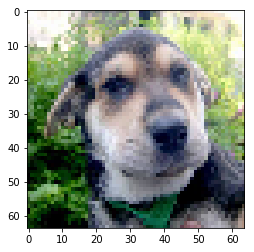

In [46]:
for batch, data in enumerate(submission_loader, 0):
    if (batch > 20):
        break
    images, numbers = data
    numbers = numbers.numpy()
    for offset, number in enumerate(numbers, 1):
        expected_number = batch * submission_loader.batch_size + offset
        assert expected_number == number, str(expected_number) + "!=" + str(number)
print ("numbering is OK")
        
image, number = submission_dataset[17]    
# to check correct number correctnessmanually
imshow(image)
print (str(number)+".jpg")

Create predictions for submission

In [ ]:
header = "id,label\n"
prediction_format = "%d,%f\n"

with open("submission4.csv", "w") as file:
    file.write(header)
    
    for data in iter(submission_loader):
        inputs, numbers = data
        inputs = Variable(inputs)

        numbers = numbers.numpy()

        # get classification and evaluate
        outputs = model(inputs).data.numpy()
        
        for pair in zip(numbers, outputs):
            line = "%d,%f\n" % pair
            file.write(line)
print ("Done.")